ChEMBL 2023-12-12 的化合物已预处理完成
本页面用于探索教程中的 smiles_to_standard_mol 是否可以在后续建模时省略

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
# load chembl smiles

with open('chembl/chembl_2023-12-12_unique.txt') as f:
    smiles = f.read().splitlines()
print(len(smiles))

1626027


COC1=CC(C=CC(=O)C=CC2=CC=C([N+](=O)[O-])C=C2)=CC=C1OCC1=CN(CCN2C(=O)C(=O)C3=CC=CC=C32)N=N1


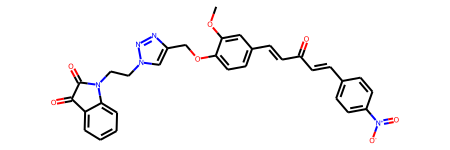

In [5]:
smi = smiles[2]
print(smi)

mol = Chem.MolFromSmiles(smi)
mol

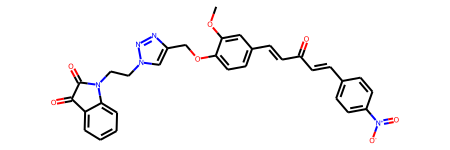

In [7]:
Chem.Kekulize(mol, clearAromaticFlags=True)
mol

In [9]:
patts = (
    # Imidazoles
    ('[n+;H]', 'n'),
    # Amines
    ('[N+;!H0]', 'N'),
    # Carboxylic acids and alcohols
    ('[$([O-]);!$([O-][#7])]', 'O'),
    # Thiols
    ('[S-;X1]', 'S'),
    # Sulfonamides
    ('[$([N-;X2]S(=O)=O)]', 'N'),
    # Enamines
    ('[$([N-;X2][C,N]=C)]', 'N'),
    # Tetrazoles
    ('[n-]', '[n]'),
    # Sulfoxides
    ('[$([S-]=O)]', 'S'),
    # Amides
    ('[$([N-]C=O)]', 'N'),
)
reactions = [(Chem.MolFromSmarts(x), Chem.MolFromSmiles(y, False)) for x, y in patts]

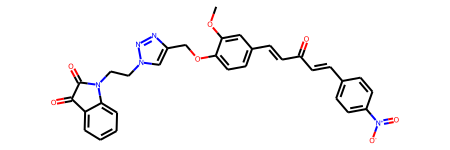

In [10]:
for reactant, product in reactions:
    while mol.HasSubstructMatch(reactant):
        mol = AllChem.ReplaceSubstructs(mol, reactant, product)[0]
mol

In [16]:
for i, smi in enumerate(smiles):
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    
    smi_in = Chem.MolToSmiles(mol)
    for reactant, product in reactions:
        while mol.HasSubstructMatch(reactant):
            mol = AllChem.ReplaceSubstructs(mol, reactant, product)[0]
    smi_out = Chem.MolToSmiles(mol)
    
    if smi_in != smi_out:
        print(i)
        print(smi_in)
        print(smi_out)

**结果**：
- 全部 160 余万分子处理前后全部一致

**结论**：
- 后续的脚本中无需再使用 reactions 去除离子的过程
- 还是需要 `Chem.Kekulzie()`，即使是读入了 Kekulized SMILES，默认读入后还是会转成 Aromatic

# 探索源码中的 `get_DGMG_smile` 函数

- Given a molecule, we are interested in what SMILES we will get if we want to generate it with DGMG
- This is an important step to check false novel molecules.

In [20]:
import random
from dgllife.model.model_zoo.dgmg import MoleculeEnv

def eval_decisions(env, decisions):
    env.reset(rdkit_mol=True)
    t = 0

    def whether_to_add_atom(t):
        assert decisions[t][0] == 0
        atom_type = decisions[t][1]
        t += 1
        return t, atom_type

    def whether_to_add_bond(t):
        assert decisions[t][0] == 1
        bond_type = decisions[t][1]
        t += 1
        return t, bond_type

    def decide_atom2(t):
        assert decisions[t][0] == 2
        dst = decisions[t][1]
        t += 1
        return t, dst

    t, atom_type = whether_to_add_atom(t)
    while atom_type != len(env.atom_types):
        env.add_atom(atom_type)
        t, bond_type = whether_to_add_bond(t)
        while bond_type != len(env.bond_types):
            t, dst = decide_atom2(t)
            env.add_bond((env.num_atoms() - 1), dst, bond_type)
            t, bond_type = whether_to_add_bond(t)
        t, atom_type = whether_to_add_atom(t)
    assert t == len(decisions)

    return env.get_current_smiles()

def get_DGMG_smiles(env, mol):
    canonical_decisions = env.get_decision_sequence(mol, list(range(mol.GetNumAtoms())))
    canonical_smile = eval_decisions(env, canonical_decisions)
    
    order = list(range(mol.GetNumAtoms()))
    random.shuffle(order)
    random_decisions = env.get_decision_sequence(mol, order)
    random_smile = eval_decisions(env, random_decisions)
    
    return canonical_smile, random_smile

In [22]:
atom_types = ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br']
bond_types = [Chem.rdchem.BondType.SINGLE,
              Chem.rdchem.BondType.DOUBLE,
              Chem.rdchem.BondType.TRIPLE]

valid_smiles = []
env = MoleculeEnv(atom_types, bond_types)

for i, smi in enumerate(smiles):
    # modify: just Kekulize
    mol = Chem.MolFromSmiles(smi)
    Chem.Kekulize(mol, clearAromaticFlags=True)
    standard_smi = Chem.MolToSmiles(mol)
    
    canonical_smi, random_smi = get_DGMG_smiles(env, mol)
    
    if (canonical_smi != random_smi) or (standard_smi != canonical_smi):
        print(i)
        print(smi)
        print(standard_smi)
        print(canonical_smi)
        print(random_smi)
    
    if i > 100: break

2
COC1=CC(C=CC(=O)C=CC2=CC=C([N+](=O)[O-])C=C2)=CC=C1OCC1=CN(CCN2C(=O)C(=O)C3=CC=CC=C32)N=N1
COC1=CC(C=CC(=O)C=CC2=CC=C([N+](=O)[O-])C=C2)=CC=C1OCC1=CN(CCN2C(=O)C(=O)C3=CC=CC=C32)N=N1
COC1=CC(C=CC(=O)C=CC2=CC=C(N(=O)O)C=C2)=CC=C1OCC1=CN(CCN2C(=O)C(=O)C3=CC=CC=C32)N=N1
COC1=CC(C=CC(=O)C=CC2=CC=C(N(=O)O)C=C2)=CC=C1OCC1=CN(CCN2C(=O)C(=O)C3=CC=CC=C32)N=N1
22
CCCCOC(=O)CNC(=O)C(CSC1=CC=C([N+](=O)[O-])C=C1[N+](=O)[O-])NC(=O)CCC(NC(=O)C(C)C)C(=O)OCCCC
CCCCOC(=O)CNC(=O)C(CSC1=CC=C([N+](=O)[O-])C=C1[N+](=O)[O-])NC(=O)CCC(NC(=O)C(C)C)C(=O)OCCCC
CCCCOC(=O)CNC(=O)C(CSC1=CC=C(N(=O)O)C=C1N(=O)O)NC(=O)CCC(NC(=O)C(C)C)C(=O)OCCCC
CCCCOC(=O)CNC(=O)C(CSC1=CC=C(N(=O)O)C=C1N(=O)O)NC(=O)CCC(NC(=O)C(C)C)C(=O)OCCCC
45
O=[N+]([O-])C1=CC=C(C2=NOC(C3=CC=C(N4CC[S+](O)CC4)C=C3)C2)O1
O=[N+]([O-])C1=CC=C(C2=NOC(C3=CC=C(N4CC[S+](O)CC4)C=C3)C2)O1
O=N(O)C1=CC=C(C2=NOC(C3=CC=C(N4CC[SH](O)CC4)C=C3)C2)O1
O=N(O)C1=CC=C(C2=NOC(C3=CC=C(N4CC[SH](O)CC4)C=C3)C2)O1
54
CCCOC1=CC=C(CCC(=O)NN=CC2=CC=C([N+](=O)[O-])O2)C=C1
CCCOC1=CC

**结果**：
- 输入的 SMILES 中存在阳离子或阴离子基团的，经过 DGMG 处理后电荷消失

**结论**：
- 经过预处理后的 ChEMBL 数据库还需要通过 `get_DGMG_smiles` 函数进一步过滤